In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Подготовим данные

In [2]:

transform = transforms.Compose(
    [transforms.ToTensor()])


batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

im size =  torch.Size([128, 3, 32, 32])


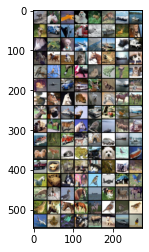

deer  dog   plane dog   deer  deer  ship  ship  bird  truck plane truck deer  ship  deer  dog   cat   frog  dog   ship  plane ship  cat   truck horse horse horse cat   horse bird  ship  cat   bird  bird  bird  cat   dog   frog  bird  cat   dog   plane car   ship  deer  dog   ship  horse cat   horse horse frog  dog   horse horse horse deer  dog   ship  deer  car   truck deer  plane truck horse horse horse bird  ship  deer  truck ship  bird  truck deer  cat   car   ship  ship  dog   horse car   frog  truck dog   bird  ship  truck car   horse horse cat   bird  truck deer  horse car   dog   dog   bird  plane car   bird  deer  dog   bird  horse ship  cat   deer  horse bird  horse horse horse horse bird  bird  bird  plane frog  bird  cat   deer  dog   car   bird 


In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('im size = ', images.size())
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Напишем автокодировщик. Будем использовать автокодировщик, основанный на свертках. Автокодировщик для cifar10 можно построить чисто на линейных слоях, но качество работы у него будет заметно хуже (протестировано).

In [81]:
class AE(nn.Module):
    def __init__(self, input_channel, hidden_channel = 18, latent_dim = 30):
        super(AE, self).__init__()

        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channel, hidden_channel, kernel_size=3, padding=1, stride=2), # 16x16
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, 2*hidden_channel, kernel_size=3, padding=1, stride=2), # 8x8
            nn.ReLU(),
            nn.Conv2d(2*hidden_channel, 2*hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2*hidden_channel, 2*hidden_channel, kernel_size=3, padding=1, stride=2), # 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2*16*hidden_channel, latent_dim)
        )
        
        self.proj = nn.Sequential(
            nn.Linear(latent_dim, 2*16*hidden_channel),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2*hidden_channel, 2*hidden_channel, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8
            nn.ReLU(),
            nn.Conv2d(2*hidden_channel, 2*hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2*hidden_channel, hidden_channel, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channel, input_channel, kernel_size=3, output_padding=1, padding=1, stride=2), # 32x32
            nn.Tanh()
        )

                
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.proj(encoded)
        decoded = decoded.reshape(decoded.shape[0], -1, 4, 4)
        decoded = self.decoder(decoded)
        return [encoded, decoded]

Класс для обучения, вывода графиков и оперирования сетью.

In [82]:
class trainer():
    def __init__(self, net, dataloader_train, dataloader_test):
        self.net = net
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.loss_function = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), weight_decay=1e-5)
        
    def train(self, epochs):
        timer = epochs//10 + 1
        L = []
        for epoch in range(epochs):
            L_mean = []
            for train_feat, train_lab in self.dataloader_train:
                train_feat = train_feat.cuda()
                _, reconstructed = self.net(train_feat)

                loss = self.loss_function(reconstructed, train_feat)
                L.append(loss.detach().cpu())
                L_mean.append(loss.detach().cpu())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
            print('loss = ', np.mean(L_mean))
            
        self.imshow(train_feat.detach().cpu())
        self.imshow(reconstructed.detach().cpu())
                    
        plt.plot(L)
        plt.show()
        
    def test(self):
        L = []
        for test_feat, test_lab in self.dataloader_test:
            test_feat = test_feat.cuda()
            _, reconstructed = self.net(test_feat)
            loss = self.loss_function(reconstructed, test_feat)
            L.append(loss.detach().cpu())
        self.imshow(test_feat.detach().cpu())
        self.imshow(reconstructed.detach().cpu())
        print(np.mean(L))

        
    def imshow(self, img):
        img = torchvision.utils.make_grid(img)
        npimg = img.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

Выберем скрытое состояние размерности 144. 

Очевидно, что в латентное пространство размерности 32 (т.е. <4 пикселей с учетом бинарной цветвоой палитры) сколь нибудь информативный набор признаков уместить невозможно. Нам нужно как минимум сохранить цветовую палитру и 4 пикселя, это 4 * 4 * 3 = 64. Это минимальный размер латентного пространства. 

При этом очевидно, при повышении размерности латентного пространства качество реконструкции будет расти. Взятая величина эквивалентна тому, что мы разбили изображение на ~7 пикселей с тремя цветовыми каналами. 

В идеале нужно провести тестирование на малом наборе данных различных значений размерности латентного пространства и построить по данным график зависимости метрики от числа параметров. Тогда начиная с определенной размерности латентного пространства его увеличение не будет значительно сказываться на метрике.

In [86]:
net = AE(input_channel=3, hidden_channel = 100, latent_dim = 144).cuda()

In [87]:
tr = trainer(net, trainloader, testloader)

loss =  0.032348786
loss =  0.012988122
loss =  0.01041269
loss =  0.009670485
loss =  0.00884662
loss =  0.008002647
loss =  0.0074265692
loss =  0.0070240176
loss =  0.006846982
loss =  0.0063697076


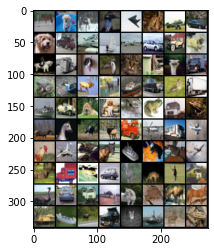

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


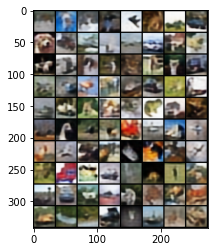

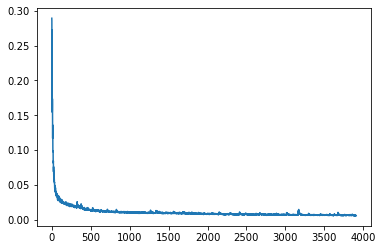

In [88]:
tr.train(10)

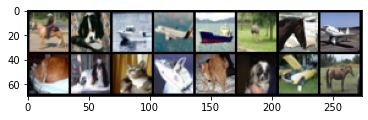

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


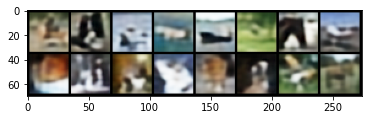

0.0058215274


In [89]:
tr.test()

На самом деле лучше себя показал в тестах автокодировщик на основе обычной сверточной сети небольшого размера (<3 слоев в кодере и декодере) типа 

encoder: conv -> batchnorm - > ReLu -> MaxPool, 

decoder: ConvTranspose2d -> batchnorm -> ReLU

(на самом деле batchnorm не показал никакого значимого эффекта).

Классификация латентных состояний, к сожалению, показала себя значительно хуже ожидаемого. Во всяком случае при использовании относительно простого классификатора.

In [90]:
classifier = nn.Sequential(
                nn.Linear(144, 150),
                nn.BatchNorm1d(150),
                nn.ReLU(),
                nn.Linear(150, 150),
                nn.BatchNorm1d(150),
                nn.ReLU(),
                nn.Linear(150, 10)
                )

In [91]:
class trainer2():
    def __init__(self, net_trained, net_class, dataloader_train, dataloader_test):
        self.net_trained = net_trained
        self.net_class = net_class
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.net_class.parameters(), lr=0.01, weight_decay=0)
        
    def train(self, epochs):
        timer = epochs//10 + 1
        L = []
        for epoch in range(epochs):
            L1 = []
            for train_feat, train_lab in self.dataloader_train:
                train_lab = train_lab.cuda()
                train_feat = train_feat.cuda()
                encoded, _ = self.net_trained(train_feat)
                
                label = self.net_class(encoded)
                
                loss = self.loss_function(label, train_lab)
                L1.append(loss.detach().cpu())

                    
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            L.append(np.mean(L1))
            print('loss = ', np.mean(L1))
                
        plt.plot(L)
        plt.show()
        
    def test(self):
        accuracy = 0.0
        total = 0.0

        for test_feat, test_lab in self.dataloader_test:
                test_lab = test_lab.cuda()
                test_feat = test_feat.cuda()
                endoded, _ = self.net_trained(test_feat)
                
                label = self.net_class(endoded)
                
                _, predicted = torch.max(label.data, 1)
                total += test_lab.size(0)
                accuracy += (predicted == test_lab).sum().item()

        print('true lab = ', test_lab)
        print('predicted lab = ', predicted)
        accuracy = (100 * accuracy / total)
        print('full acc = ', accuracy)

In [92]:
net_class = classifier.cuda()

In [93]:
tr2 = trainer2(net, net_class, trainloader, testloader)

loss =  1.5582169
loss =  1.3506364
loss =  1.2638408
loss =  1.1946759
loss =  1.1470703
loss =  1.1018128
loss =  1.0655234
loss =  1.0343747
loss =  0.999081
loss =  0.9727067
loss =  0.93944454
loss =  0.924785
loss =  0.89875096
loss =  0.876676
loss =  0.8554321
loss =  0.8378947
loss =  0.8223443
loss =  0.8081531
loss =  0.79051954
loss =  0.7747134
loss =  0.7633753
loss =  0.75046957
loss =  0.74231964
loss =  0.7257087
loss =  0.7221022
loss =  0.7094919
loss =  0.70181346
loss =  0.69386137
loss =  0.6837908
loss =  0.6768196
loss =  0.6673021
loss =  0.6611894
loss =  0.6615703
loss =  0.6462587
loss =  0.6447
loss =  0.63753945
loss =  0.6268567
loss =  0.62555724
loss =  0.6182968
loss =  0.6143111
loss =  0.6188831
loss =  0.60568076
loss =  0.59854674
loss =  0.59824926
loss =  0.5941068
loss =  0.5877144
loss =  0.5823452
loss =  0.5828364
loss =  0.57932687
loss =  0.5696256
loss =  0.57156926
loss =  0.5694861
loss =  0.5612725
loss =  0.56055427
loss =  0.5519858
l

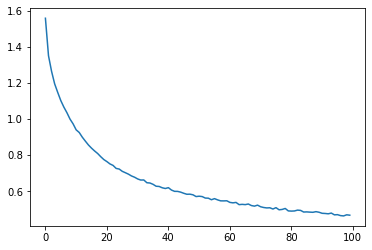

In [94]:
tr2.train(100)

In [95]:
tr2.test()

true lab =  tensor([7, 5, 8, 0, 8, 2, 7, 0, 3, 5, 3, 8, 3, 5, 1, 7], device='cuda:0')
predicted lab =  tensor([7, 3, 8, 8, 8, 2, 7, 9, 3, 3, 4, 8, 2, 2, 4, 7], device='cuda:0')
full acc =  49.11


Выводы:
В принципе, даже относительно простой автокодировщик на линейных слоях способен относительно (весьма относительно) хорошо обучаться кодировать и декодировать изображение. При этом однако, простейший классификатор на латентном представлении не дает сходу качественного результата в плане accuracy (при множестве тестов лучший результат - 56%).

Проблемы могут находиться в двух областях:

1) Недостаточно информативное латентное пространство. Очевидно, что качество классификации сильно зависит от информативности латентного представления автокодировщика.

2) Мощность самого классификатора. Из за того, что пространство полученных из автоэнкодера признаков не имеет какой то интуитивно-понятной структуры, не понятно сходу, какого типа архитектуры будут лучше применимы к таким "сжатым" данным.

Очевидные решения:

1) Варьировать размерность латентного представления автокодировщика

2) Варьировать архитектуры сети-классификатора и автоэнкодера (в т.ч. размерности скрытых слоев, etc)

3) Варьировать аугментации входных данных

4) Увеличить время обучения (по графикам функции потерь видно, что они на момент завершения обучения еще не вышли на плато)

5) Варьировать гиперпараметры

Менее очевидные решения:

1) Можно попытаться заставить сеть учить не произвольное латентное представление, а как то структурировать его, наложив дополнительные ограничения на латентное пространство. Например, обучать не абстрактную сеть, а какой то оператор отображения, который участвует в процедуре редуцирования размерности входных данных. При этом для данного оператора мы можем заранее знать некоторые аналитические свойства (похожие вещи используются как в вариационных автоэнкодерах, так и в manifold learning). Конкретные операторы и свойства зависят от пространства задачи.

2) Можно попробовать заменить в энкодере функции активации на Siren и построить что то вроде implicit image compression.

Предыдущие эксперименты:

In [96]:
class AE(nn.Module):
    def __init__(self, input_channel, layers = 3):
        super(AE, self).__init__()

        
        enc = []
        for i in range(layers):
            enc.append(nn.Conv2d(input_channel*(2**i), input_channel*(2**(i+1)), 2, stride = 1, padding = 1))
            enc.append(nn.BatchNorm2d(input_channel*(2**(i+1))))
            enc.append(nn.ReLU())
            enc.append(nn.MaxPool2d(2,2))
        self.encoder = nn.Sequential(*enc)

 
        dec = []
        for i in range(layers-1):
            dec.append(nn.ConvTranspose2d(input_channel*(2**(layers - i)), input_channel*(2**(layers - i - 1)), 4, stride=2, padding=1))
#            dec.append(nn.BatchNorm2d(input_channel*(2**(layers - i - 1))))
            dec.append(nn.ReLU())
#            enc.append(nn.MaxPool2d(2,2))
        
        dec.append(nn.ConvTranspose2d(input_channel*2, input_channel, 4, stride=2, padding=1))
        dec.append(nn.Sigmoid())
        
        self.decoder = nn.Sequential(*dec)

        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return [encoded, decoded]

In [97]:
net = AE(input_channel=3, layers=3).cuda()

In [98]:
tr = trainer(net, trainloader, testloader)

loss =  0.025513398
loss =  0.015409307
loss =  0.014021918
loss =  0.013424582
loss =  0.012833338
loss =  0.012470562
loss =  0.0120303305
loss =  0.011669064
loss =  0.011481256
loss =  0.0111546405
loss =  0.0109210005
loss =  0.010761
loss =  0.01063532
loss =  0.0104394555
loss =  0.010333426
loss =  0.010202625
loss =  0.010133281
loss =  0.010038112
loss =  0.009943882
loss =  0.009894873


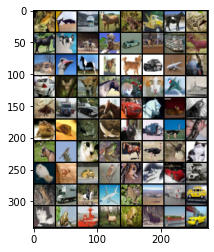

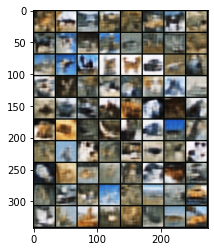

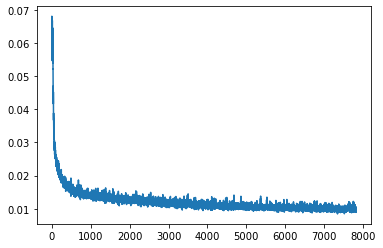

In [99]:
tr.train(20)

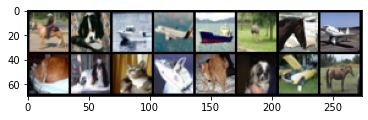

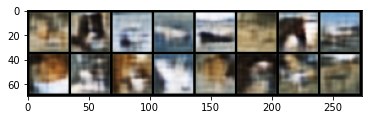

0.009654656


In [100]:
tr.test()

In [101]:
classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(24*4*4, 150),
                nn.BatchNorm1d(150),
                nn.ReLU(),
                nn.Linear(150, 150),
                nn.BatchNorm1d(150),
                nn.ReLU(),
                nn.Linear(150, 10)
                )
net_class = classifier.cuda()

In [102]:
tr2 = trainer2(net, net_class, trainloader, testloader)

loss =  1.408477
loss =  1.2190634
loss =  1.128667
loss =  1.0675821
loss =  1.0106994
loss =  0.96084416
loss =  0.91360074
loss =  0.8726304
loss =  0.83370155
loss =  0.7975425
loss =  0.7607497
loss =  0.72977066
loss =  0.70188355
loss =  0.6708689
loss =  0.64252853
loss =  0.6189512
loss =  0.60059786
loss =  0.57383937
loss =  0.5591867
loss =  0.53826815
loss =  0.52218044
loss =  0.50776285
loss =  0.48600563
loss =  0.480118
loss =  0.45715234
loss =  0.44505462
loss =  0.44117764
loss =  0.4319283
loss =  0.41968578
loss =  0.4068617
loss =  0.4004669
loss =  0.38490713
loss =  0.3847344
loss =  0.37049034
loss =  0.36107135
loss =  0.35735172
loss =  0.3476807
loss =  0.34210354
loss =  0.33769697
loss =  0.32960904
loss =  0.3257172
loss =  0.3236118
loss =  0.3143755
loss =  0.31825235
loss =  0.30305213
loss =  0.3010835
loss =  0.29937026
loss =  0.28836966
loss =  0.2871905
loss =  0.2899923
loss =  0.28385183
loss =  0.2716743
loss =  0.27237037
loss =  0.27525178
l

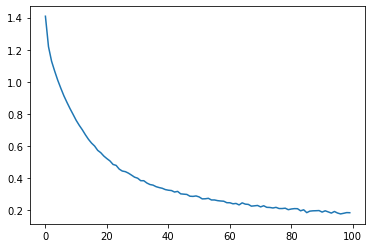

In [103]:
tr2.train(100)

In [104]:
tr2.test()

true lab =  tensor([7, 5, 8, 0, 8, 2, 7, 0, 3, 5, 3, 8, 3, 5, 1, 7], device='cuda:0')
predicted lab =  tensor([4, 5, 0, 8, 8, 4, 7, 8, 9, 3, 6, 8, 6, 2, 1, 7], device='cuda:0')
full acc =  54.22


Автокодировщик на линейных слоях

In [105]:
class AE_lin(nn.Module):
    def __init__(self, input_size, hidden_dim = 150, latent_size = 150, layers = 3):
        super(AE_lin, self).__init__()

        encod = [nn.Flatten(), nn.Linear(input_size**2*3, hidden_dim), nn.ReLU()]
        
        for i in range(layers-1):
            encod.append(nn.Linear(hidden_dim, hidden_dim))
            encod.append(nn.BatchNorm1d(hidden_dim))
            encod.append(nn.ReLU())
            
        encod.append(nn.Linear(hidden_dim, latent_size))
        self.encoder = nn.Sequential(*encod)
        
        decod = [nn.Linear(latent_size, hidden_dim)]

        for i in range(layers-1):
            decod.append(nn.Linear(hidden_dim, hidden_dim))
            decod.append(nn.BatchNorm1d(hidden_dim))
            decod.append(nn.ReLU())
            
        decod.append(nn.Linear(hidden_dim, input_size**2*3))
        decod.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decod)
        
    def forward(self, x):
        b_size = x.size(0)
        c_size = x.size(1)
        im_size = x.size(2)
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape([b_size, c_size, im_size, im_size])
        return [encoded, decoded]

In [106]:
net = AE_lin(input_size=32, layers=3).cuda()

In [107]:
tr = trainer(net, trainloader, testloader)

loss =  0.028153704
loss =  0.022975609
loss =  0.022167712
loss =  0.021306884
loss =  0.020306014
loss =  0.019975826
loss =  0.019515218
loss =  0.019143878
loss =  0.018796671
loss =  0.018400887
loss =  0.018266158
loss =  0.018057868
loss =  0.017867055
loss =  0.01758156
loss =  0.017497813
loss =  0.017365342
loss =  0.017130723
loss =  0.017094586
loss =  0.017034331
loss =  0.016979076
loss =  0.016916834
loss =  0.016713222
loss =  0.016623337
loss =  0.016603963
loss =  0.016521197
loss =  0.016510023
loss =  0.016493337
loss =  0.0164888
loss =  0.016386162
loss =  0.01620052
loss =  0.016184524
loss =  0.016102642
loss =  0.016066218
loss =  0.016056204
loss =  0.01592914
loss =  0.015783021
loss =  0.015787035
loss =  0.015756609
loss =  0.01573871
loss =  0.015757477
loss =  0.015772909
loss =  0.015692322
loss =  0.015714267
loss =  0.01572145
loss =  0.015709365
loss =  0.015728697
loss =  0.015681446
loss =  0.015674254
loss =  0.015729904
loss =  0.015649268


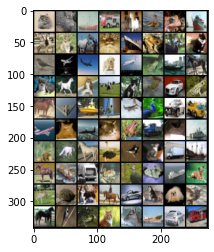

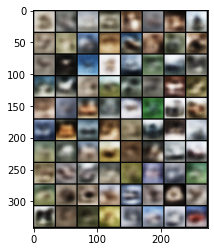

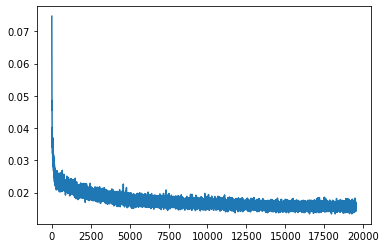

In [108]:
tr.train(50)

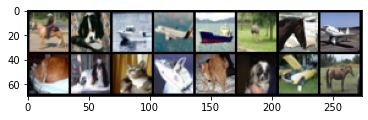

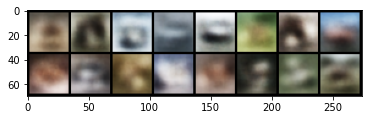

0.015810305


In [109]:
tr.test()